<H2>Step1. 資料預處理</H2>

In [1]:
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers import Embedding, BatchNormalization
from keras.datasets import mnist
import numpy as np

%matplotlib inline

In [2]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train.shape

(60000, 28, 28)

In [3]:
from keras.utils import np_utils
x_train_shaped = (x_train.reshape(60000, 784).astype('float32') - 127.5)/127.5 # reshape讓他從32*32變成784*1的一維陣列，# 並標準化到-1~1 區間
x_test_shaped = (x_test.reshape(10000, 784).astype('float32') - 127.5)/127.5

<H2>Step2. 建立創作家</H2>

In [4]:
random_dim = 100
generator = Sequential()
generator.add(Dense(256, input_dim=random_dim, activation='relu', kernel_initializer='random_normal'))
generator.add(BatchNormalization())
generator.add(Dense(512, activation='relu', kernel_initializer='random_normal'))
generator.add(BatchNormalization())
generator.add(Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer='adam')
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 784)               402192    
Total params: 562,704
Trainable params: 561,168
Non-trainable params: 1,536
_________________________________________________________________


<H2>Step3. 建立鑑賞家</H2>

In [5]:
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784, activation='relu', kernel_initializer='random_normal'))
discriminator.add(Dropout(0.25))
discriminator.add(Dense(512, activation='relu', kernel_initializer='random_normal'))
discriminator.add(Dropout(0.25))
discriminator.add(Dense(256, activation='relu', kernel_initializer='random_normal'))
discriminator.add(Dropout(0.25))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1024)              803840    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

<H2>Step4. 組合網路</H2>

In [6]:
discriminator.trainable = False #只是訓練創作家，所以要把鑑賞家的參數固定住，直接設置trainable = False即可。
gan_input = Input(shape=(random_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 784)               562704    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1460225   
Total params: 2,022,929
Trainable params: 561,168
Non-trainable params: 1,461,761
_________________________________________________________________


In [7]:
batch_size = 200
epoch_count = 20
d_loss_list = []
g_loss_list = []
for epoch in range(0, epoch_count):
    for batch_count in range(0, 300):
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs = x_train_shaped[idx]
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        # 步驟0: 讓創作家製造出fake image
        noise = np.random.randint(0, 1, (batch_size, random_dim))
        gen_imgs = generator.predict(noise)
        discriminator.trainable = True
        # 步驟1: 讓鑑賞家鑑賞對的image
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        # 步驟2: 讓鑑賞家鑑賞錯的image
        d_loss_fake = discriminator.train_on_batch(imgs, fake)
        d_loss = (d_loss_real + d_loss_fake) / 2
        discriminator.trainable = False
        noise = np.random.normal(0, 1, (batch_size, random_dim))
        # 步驟3: 訓練創作家的創作能力
        g_loss = gan.train_on_batch(noise, valid)
    dash = '-'*15
    print(dash, 'epoch', epoch, dash)
    print('Discriminator Loss:', d_loss)
    print('Generator loss:', g_loss)
    d_loss_list.append(d_loss)
    g_loss_list.append(g_loss)

--------------- epoch 0 ---------------
Discriminator Loss: 0.6999029517173767
Generator loss: 0.031919214874506
--------------- epoch 1 ---------------
Discriminator Loss: 0.6925696432590485
Generator loss: 0.01904514618217945
--------------- epoch 2 ---------------
Discriminator Loss: 0.6936615705490112
Generator loss: 0.016420193016529083
--------------- epoch 3 ---------------
Discriminator Loss: 0.6934278011322021
Generator loss: 0.011992765590548515
--------------- epoch 4 ---------------
Discriminator Loss: 0.6930077970027924
Generator loss: 0.01623130403459072
--------------- epoch 5 ---------------
Discriminator Loss: 0.693705677986145
Generator loss: 0.013450834900140762
--------------- epoch 6 ---------------
Discriminator Loss: 0.6933747828006744
Generator loss: 0.011433199979364872
--------------- epoch 7 ---------------
Discriminator Loss: 0.6932129859924316
Generator loss: 0.010425141081213951
--------------- epoch 8 ---------------
Discriminator Loss: 0.693259209394455


<H2>Step5. 訓練結果</H2>

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

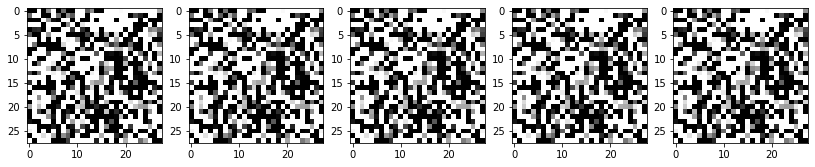

In [9]:
examples = 5
noise = np.random.normal(0, 1, (examples, random_dim))
gen_imgs = generator.predict(noise)

gen_imgs = 0.5*gen_imgs+0.5
gen_imgs = gen_imgs.reshape(examples, 28, 28)
plt.figure(figsize=(14,14))
for i in range(0, examples):
    plt.subplot(1, examples, 1+i)
    plt.imshow(gen_imgs[i], cmap='gray')